## import Model

In [31]:
## import system liberaries
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

## import data handeling Tools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


## import deep learning liberaries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,BatchNormalization, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax

## prevent warnings
import warnings
warnings.filterwarnings('ignore')

import kagglehub



# Data Preprocessing

## Read Data

In [32]:

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [33]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

filepaths = []
labels = []

In [34]:

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

In [35]:
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [36]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [37]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

## Split dataframe into train, valid, and test

In [38]:
valid_df, test_df = train_test_split(ts_df, test_size=0.5, random_state=123,shuffle=True)

## Create image data generator

In [39]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show sample from train data

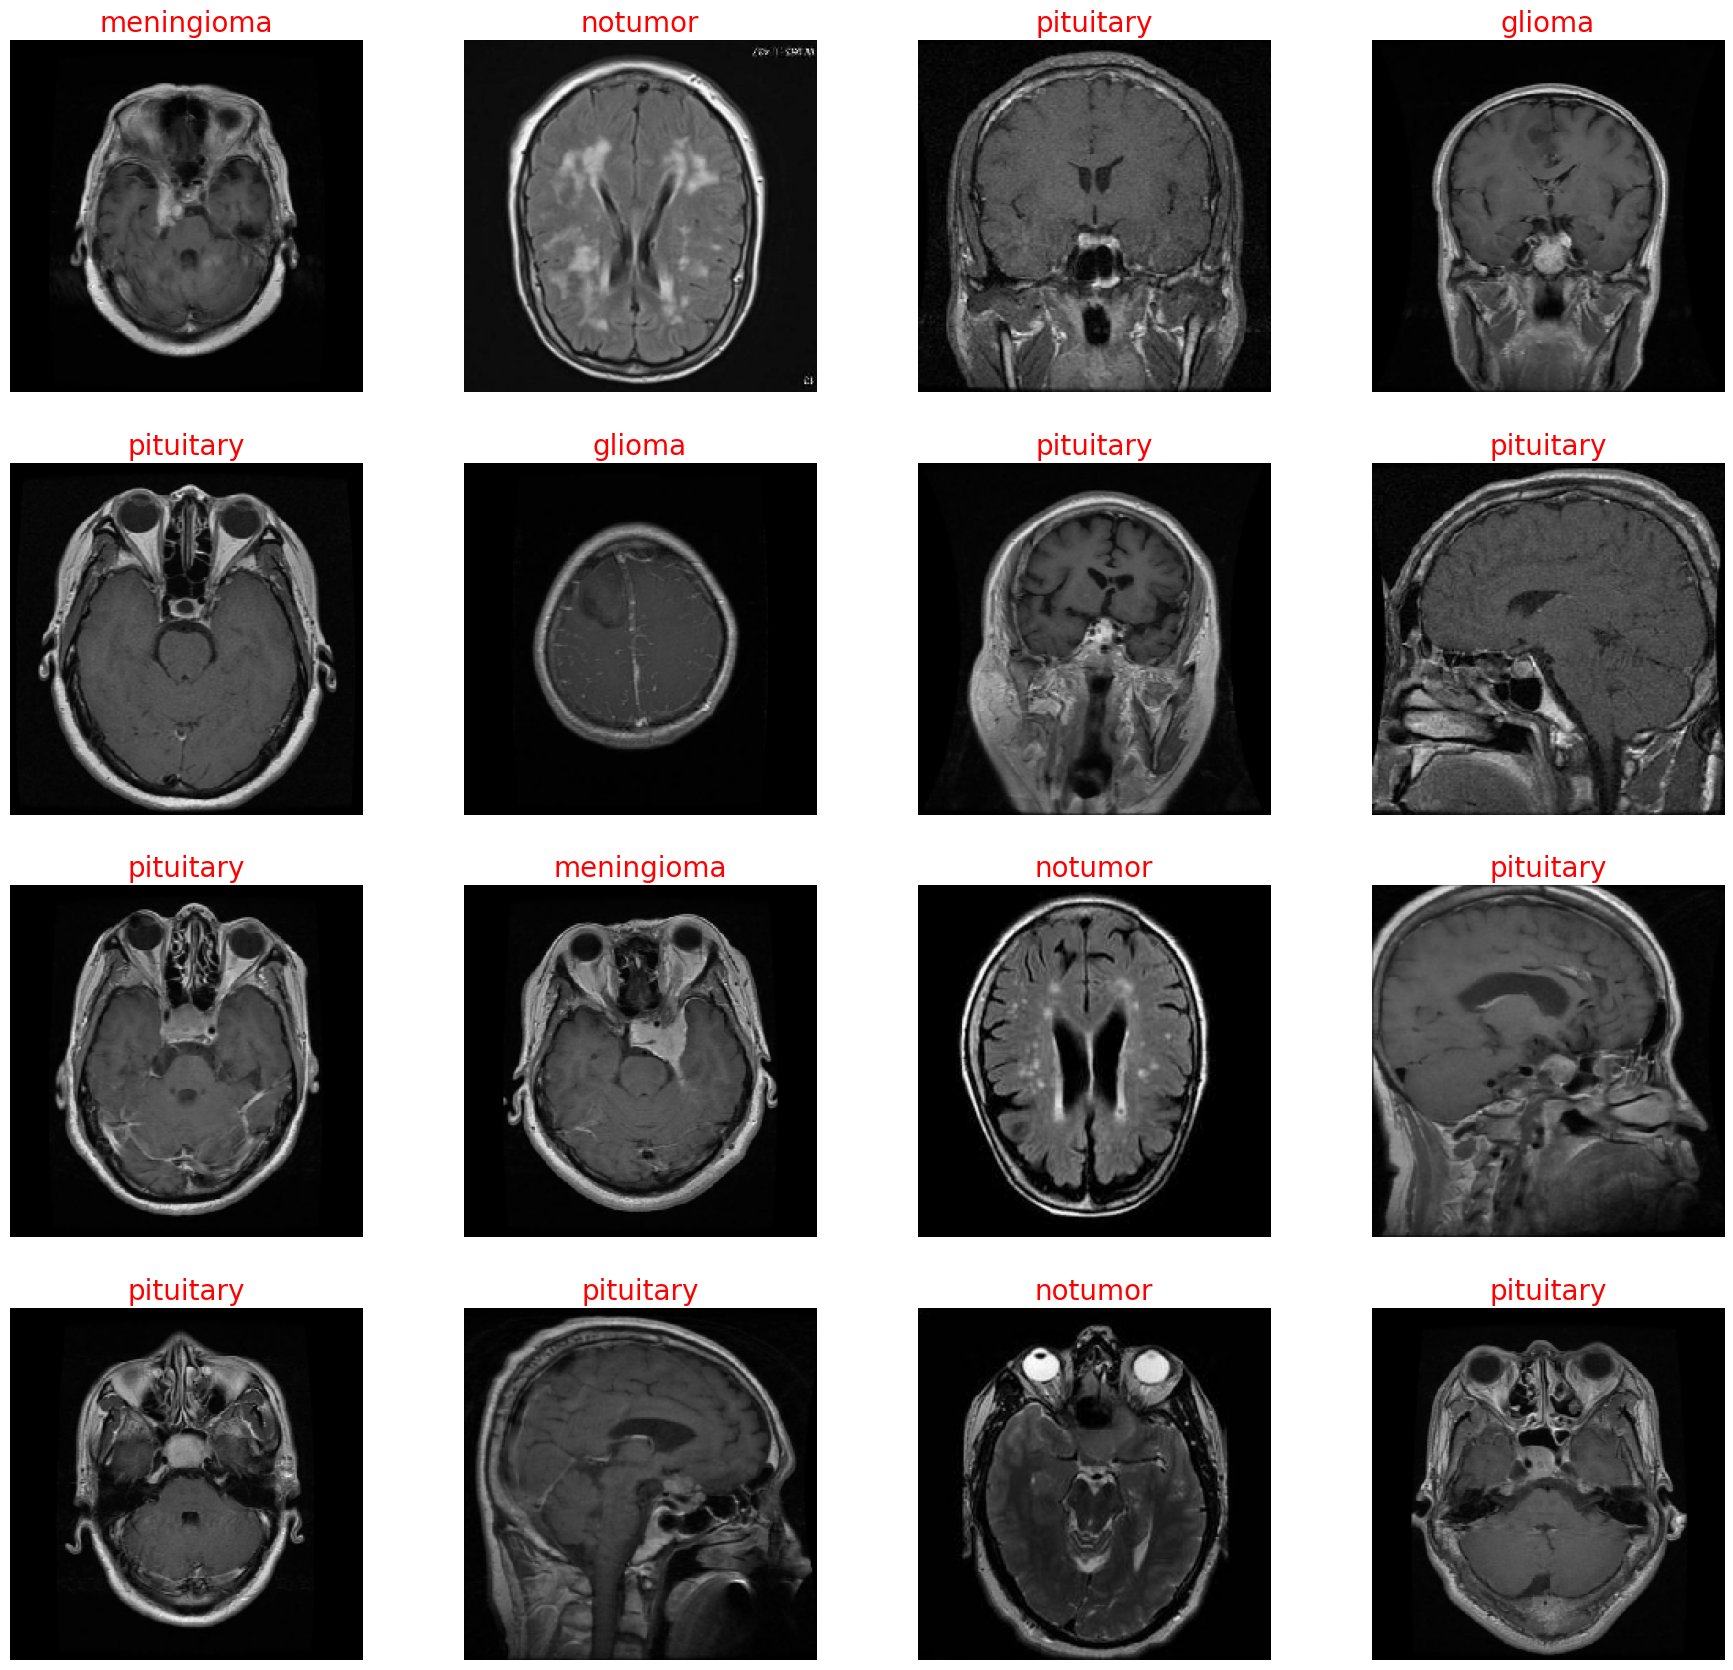

In [40]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'red', fontsize= 20)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [41]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
#base_model.trainable = True

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006), # Changed the 'l' argument to a positional argument
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

# Train model

In [42]:
epochs = 10
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 176s 184ms/step - accuracy: 0.6058 - loss: 10.6779 - val_accuracy: 0.6947 - val_loss: 5.5764
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 150ms/step - accuracy: 0.5543 - loss: 5.0943 - val_accuracy: 0.6962 - val_loss: 3.6849
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 152ms/step - accuracy: 0.6406 - loss: 3.3916 - val_accuracy: 0.7130 - val_loss: 2.4565
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 150ms/step - accuracy: 0.7018 - loss: 2.3072 - val_accuracy: 0.8763 - val_loss: 1.6064
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.8253 - loss: 1.6072 - val_accuracy: 0.9710 - val_loss: 1.0736
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 151ms/step - accuracy: 0.8566 - loss: 1.1807 - val_accuracy: 0.9725 - val_loss: 0.8516
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 150ms/step - accuracy: 0.8649 - loss: 0.9669 - val_accuracy: 0.9863 - val_loss: 0.6597
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.8744 - loss:

## Display Model Performance

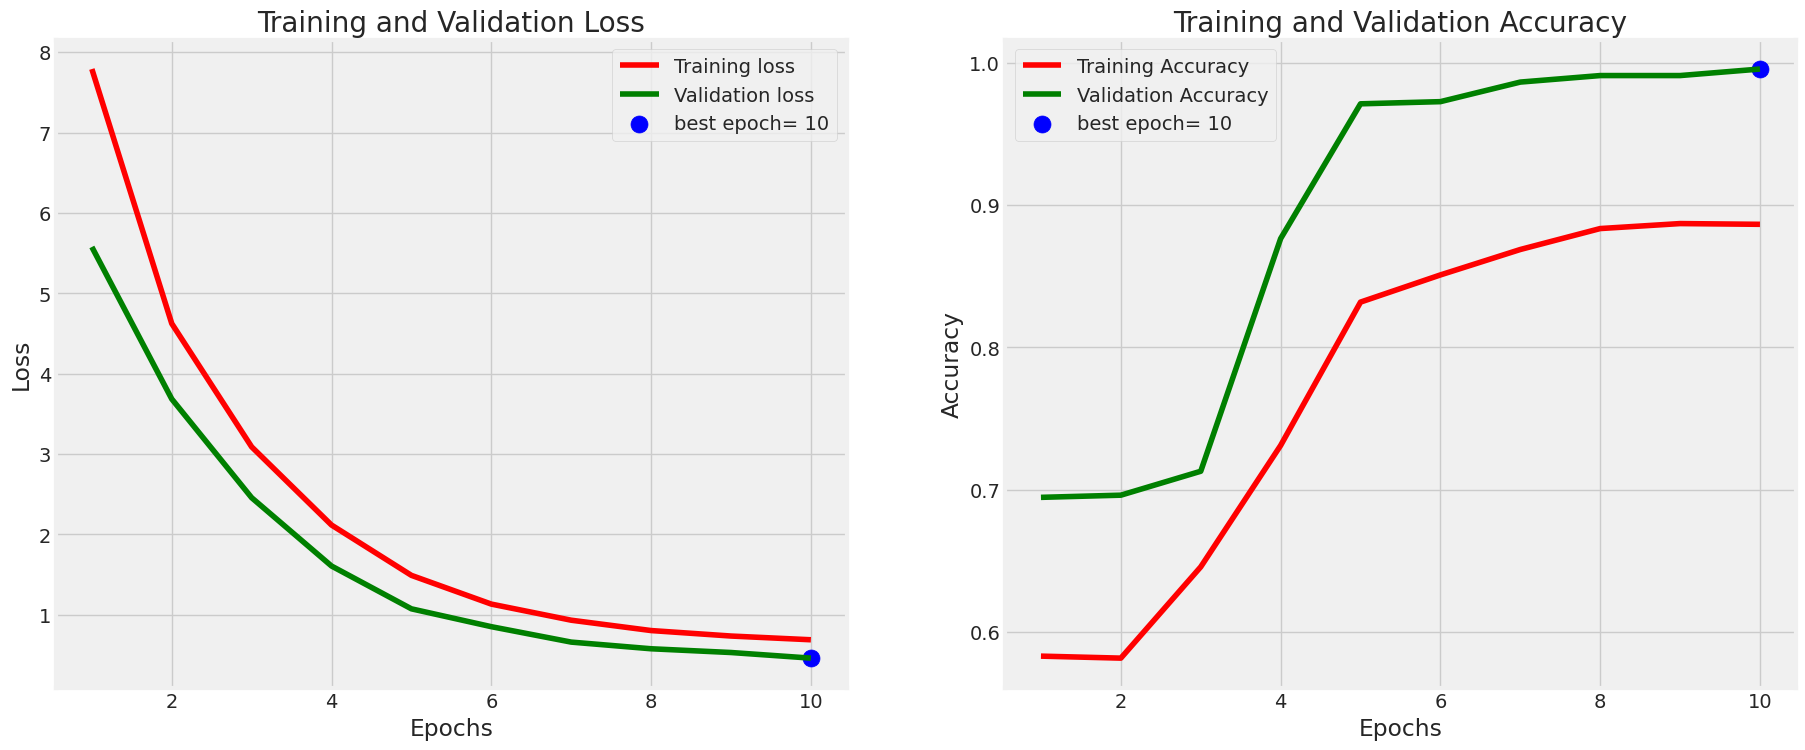

In [43]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [44]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 1.0000 - loss: 0.4460
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9897 - loss: 0.4681
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9914 - loss: 0.4614
Train Loss:  0.44301241636276245
Train Accuracy:  1.0
--------------------
Validation Loss:  0.46941179037094116
Validation Accuracy:  0.9921875
--------------------
Test Loss:  0.46992796659469604
Test Accuracy:  0.98828125


# Get Predictions

In [45]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step


## Confusion Matrics and Classification Report

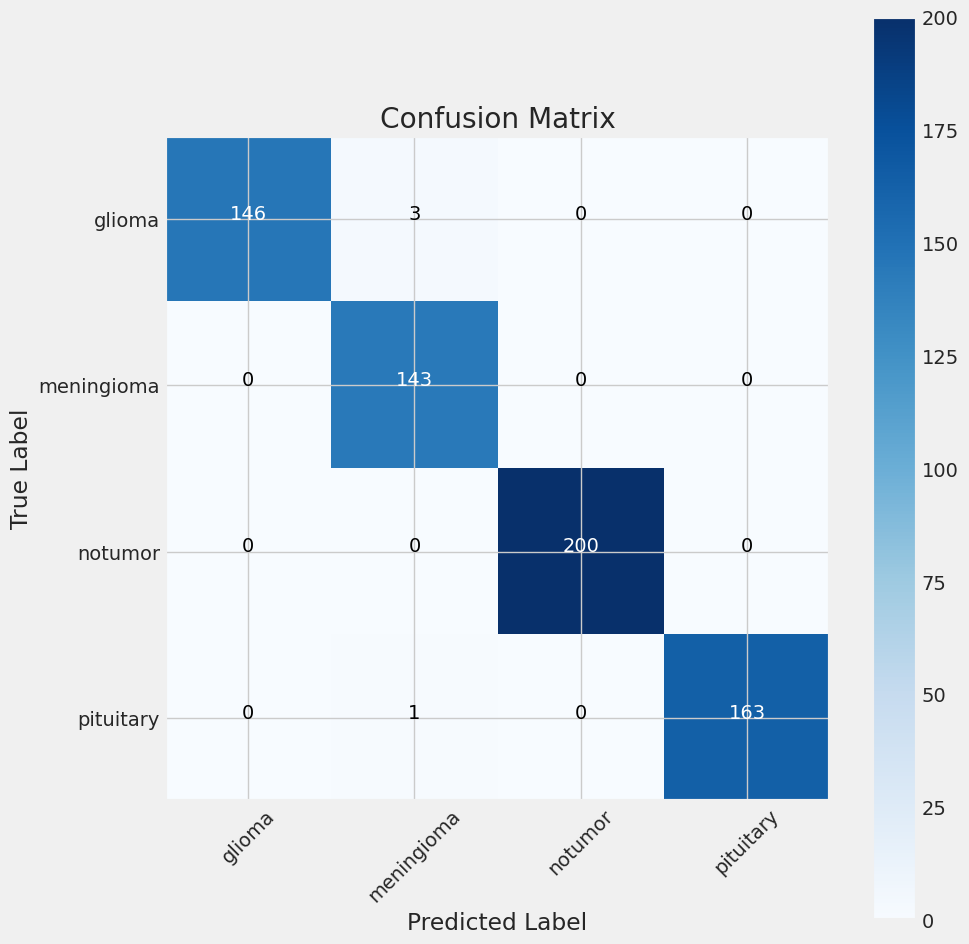

In [46]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [47]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       149
  meningioma       0.97      1.00      0.99       143
     notumor       1.00      1.00      1.00       200
   pituitary       1.00      0.99      1.00       164

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



# Save Model

In [48]:
model.save('Brain Tumors.keras')

## Prediction using loaded_model

In [49]:
model.save('brain_tumors.h5')  # No need for `save_format='h5'`

loaded_model = tf.keras.models.load_model('brain_tumors.h5', compile=False)


In [50]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0004.jpg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
No Tumor


## Convert to tflite

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('Brain.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmph2s01bzu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1954')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139505904031824: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139505904033168: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139507443159824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443159440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443160400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443165008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443170576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443164432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139507443165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505920007376: TensorSpec(shape=(), dtype=tf.resource, name